In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import os, sys

def get_dir_n_levels_up(path, n):
    # Go up n levels from the given path
    for _ in range(n):
        path = os.path.dirname(path)
    return path


proj_root = get_dir_n_levels_up(os.path.abspath("__file__"), 4)
sys.path.append(proj_root)

print(proj_root)

d:\Work\repos\RL\phd-rl-algos


In [45]:
import yaml
import torch
import numpy as np
import pandas as pd
import seaborn as sns

from dqn.opinion_dynamics.utils.my_logging import setup_logger
from dqn.opinion_dynamics.utils.env_setup import EnvironmentFactory
from dqn.opinion_dynamics.utils.experiment import instantiate_agent
from dynamic_programming.opinion_dynamics.common.viz import (
    interpolate_opinion_trajectory,
    plot_action_heatmap,
    plot_opinions_over_time,
)
from dqn.opinion_dynamics.experiments.baseline import flatten_intermediate_states_np, run_policy_agent



In [46]:
import numpy as np
import pandas as pd
import seaborn as sns

from rl_envs_forge.envs.network_graph.network_graph import NetworkGraph
from dqn.opinion_dynamics.utils.env_setup import build_environment, EnvironmentFactory
from dqn.opinion_dynamics.experiments.baseline import run_policy, run_centrality_policy, flatten_intermediate_states_np
from dqn.opinion_dynamics.experiments.algos import centrality_based_continuous_control

from dynamic_programming.opinion_dynamics.algos import compute_average_error, compute_final_average_error, generate_full_control_policy, generate_control_from_vector
from dynamic_programming.opinion_dynamics.algo_infinite_horizon import value_iteration, extract_policy, create_state_grid
from dynamic_programming.opinion_dynamics.common.viz import plot_opinions_over_time, visualize_policy_from_env, plot_action_heatmap, interpolate_opinion_trajectory

2025-09-15 18:43:40,498 - dqn - INFO - opinion_dqn.py:266 - Loaded configuration settings.
2025-09-15 18:43:40,501 - dqn - INFO - opinion_dqn.py:328 - Initialized networks and optimizer.


2025-09-15 18:43:44,977 - dqn - INFO - opinion_dqn.py:211 - Loaded previous training status from the following files: {'replay_buffer_file': 'd:\\Work\\repos\\RL\\phd-rl-algos\\dqn\\opinion_dynamics\\experiments\\results\\2025Sep15-090310_configs\\0000_optim.args_.lr_1e-05__agent_params.args_.betas__0__1__2___agent_params.model_OpinionNetCommonAB__experiment_opinion_agent_dqn_fixed_steps\\1\\opinion_agent_dqn_fixed_steps_replay_buffer', 'train_stats_file': 'd:\\Work\\repos\\RL\\phd-rl-algos\\dqn\\opinion_dynamics\\experiments\\results\\2025Sep15-090310_configs\\0000_optim.args_.lr_1e-05__agent_params.args_.betas__0__1__2___agent_params.model_OpinionNetCommonAB__experiment_opinion_agent_dqn_fixed_steps\\1\\opinion_agent_dqn_fixed_steps_train_stats', 'checkpoint_model_file': 'd:\\Work\\repos\\RL\\phd-rl-algos\\dqn\\opinion_dynamics\\experiments\\results\\2025Sep15-090310_configs\\0000_optim.args_.lr_1e-05__agent_params.args_.betas__0__1__2___agent_params.model_OpinionNetCommonAB__experim

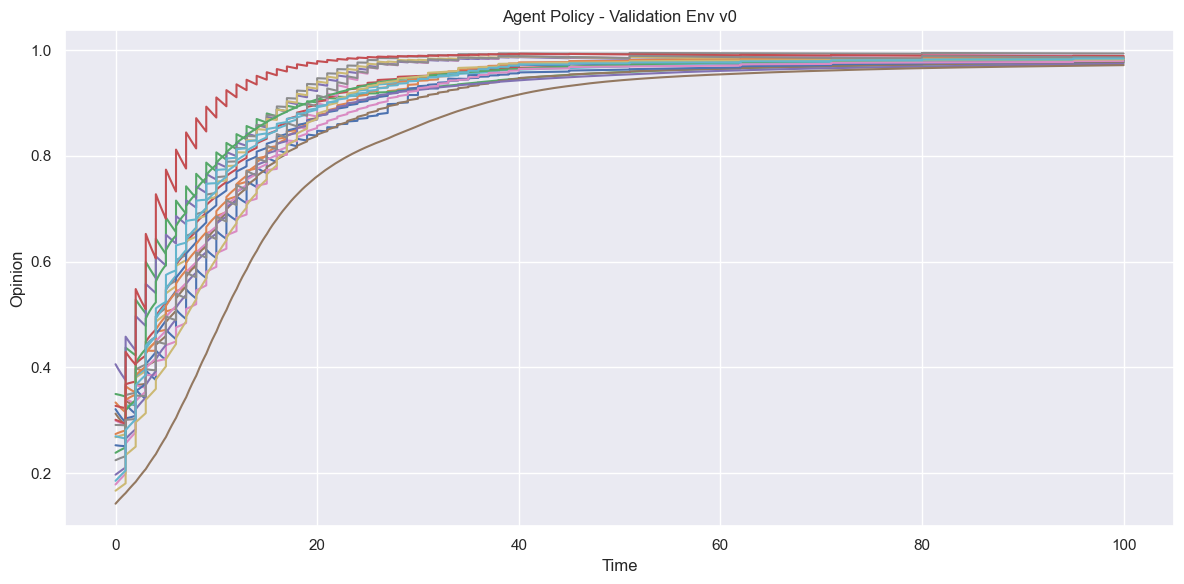

Total discounted reward: -10.3625

--- Running agent on validation environment version 1 ---
Simulation ended at step 99: done=False, truncated=True


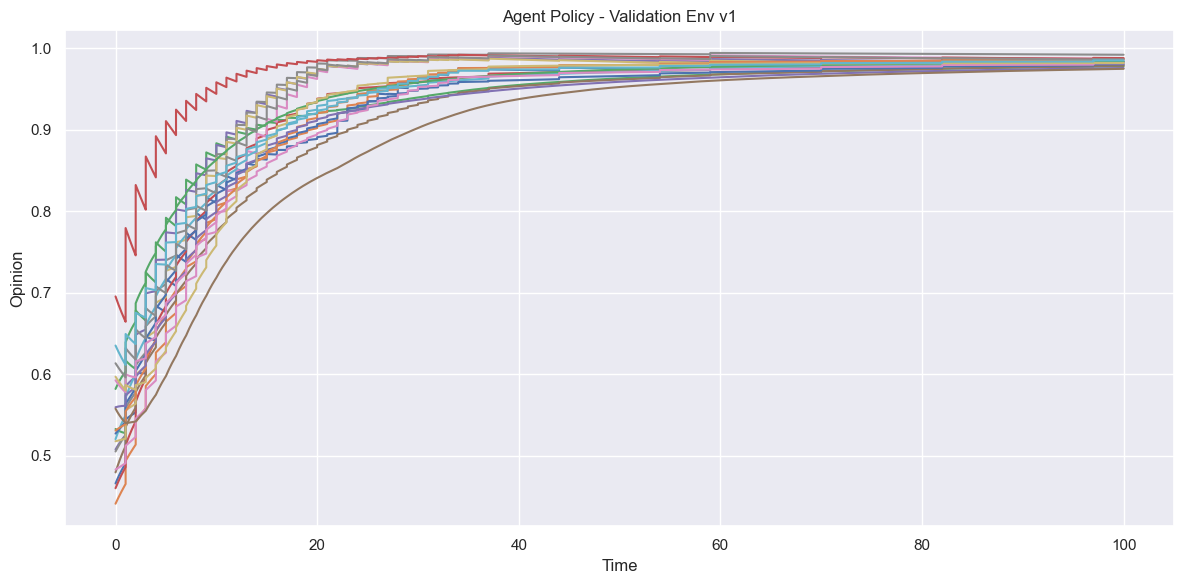

Total discounted reward: -7.0164

--- Running agent on validation environment version 2 ---
Simulation ended at step 99: done=False, truncated=True


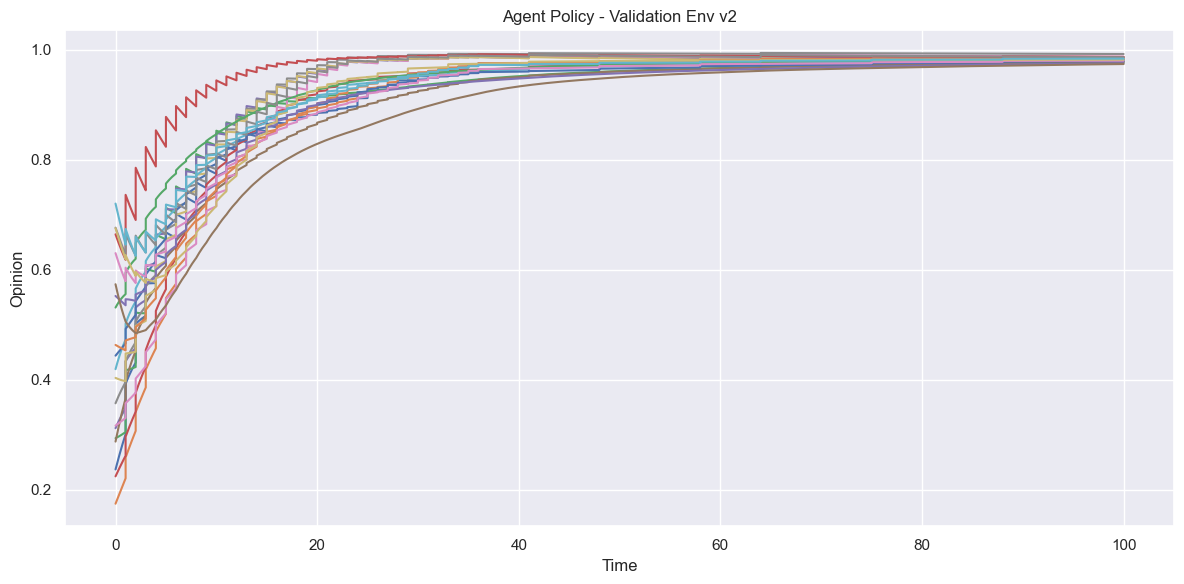

Total discounted reward: -8.0394
   version  discounted_reward
0        0         -10.362483
1        1          -7.016441
2        2          -8.039370


In [47]:
# exp_subdir = r"d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Sep11-034202_configs\0000_optim.args_.lr_1e-05__agent_params.args_.betas__0__1__2___agent_params.model_OpinionNetCommonAB__experiment_opinion_agent_dqn_fixed_steps\2"
exp_subdir = r"d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Sep15-090310_configs\0000_optim.args_.lr_1e-05__agent_params.args_.betas__0__1__2___agent_params.model_OpinionNetCommonAB__experiment_opinion_agent_dqn_fixed_steps\1"

agent = instantiate_agent(exp_subdir)

results = []
df_actions_list = []

env_versions = agent.env_factory.validation_versions
# env_versions = [0]

for version in range(len(env_versions)):
    print(f"\n--- Running agent on validation environment version {version} ---")

    # Force environment to version
    agent.validation_env = agent.env_factory.get_validation_env(version=version)

    # Run policy with agent
    states, times, rewards, actions, all_intermediate_states = run_policy_agent(agent)

    actions_np = np.asarray(actions)                 # shape (T, N)
    T, N = actions_np.shape[0], actions_np.shape[1]

    df_actions_v = pd.DataFrame(
        actions_np,
        columns=[f"a_{j}" for j in range(N)]
    )
    df_actions_v.insert(0, "t_idx", np.arange(T))
    df_actions_v.insert(0, "version", version)

    df_actions_list.append(df_actions_v)

    flat_states, flat_times = flatten_intermediate_states_np(
        all_intermediate_states,
        agent.validation_env.t_campaign,
        agent.validation_env.t_s
    )
    plot_opinions_over_time(flat_states, flat_times, title=f"Agent Policy - Validation Env v{version}")

    total_value = sum((agent.gamma ** i) * r for i, r in enumerate(rewards))
    print(f"Total discounted reward: {total_value:.4f}")
    results.append({"version": version, "discounted_reward": total_value})

# Per-version results (unchanged)
df_results_agent = pd.DataFrame(results)
print(df_results_agent)


In [48]:

def build_budget_schedule_from_df(df_actions: pd.DataFrame, version: int, num_steps: int, fill: float = 0.0) -> np.ndarray:
    """
    From df_actions (columns: version, t_idx, a_0..a_{N-1}), build a length `num_steps`
    vector of per-step budgets for the given version.
    """
    df_v = df_actions[df_actions["version"] == version].sort_values("t_idx")
    if df_v.empty:
        return np.zeros(num_steps, dtype=float)

    action_cols = [c for c in df_v.columns if c.startswith("a_")]
    s = df_v[action_cols].sum(axis=1).to_numpy(dtype=float)  # per-step sum (mass)

    # clean + size to match num_steps
    s = np.clip(np.nan_to_num(s, nan=fill), 0.0, None)
    if len(s) >= num_steps:
        s = s[:num_steps]
    else:
        s = np.pad(s, (0, num_steps - len(s)), mode="constant", constant_values=fill)
    return s

def run_uniform_policy_with_schedule(env, budget_schedule: np.ndarray, max_steps: int):
    """
    Runs a uniform broadcast where at step t each node gets b_t / N,
    with b_t from `budget_schedule`.
    Returns (opinions_over_time, time_points, rewards, actions, intermediary_states).
    """
    s, info = env.reset()
    opinions_over_time = [np.array(s, copy=True)]
    time_points, rewards, actions, intermediary_states = [], [], [], []
    is_terminated = False
    truncated = False
    N = env.num_agents

    for t, b_t in enumerate(budget_schedule[:max_steps]):
        u_t = np.full(N, float(b_t) / N, dtype=float)

        s_next, r, is_terminated, truncated, info = env.step(u_t)

        opinions_over_time.append(np.array(s_next, copy=True))
        actions.append(np.array(u_t, copy=True))
        rewards.append(float(r))
        time_points.append(float(getattr(env, "t_current", t)))

        inter = info.get("intermediate_states") if isinstance(info, dict) else None
        intermediary_states.append(inter)

        if is_terminated or truncated:
            break

    return (
        np.asarray(opinions_over_time),
        np.asarray(time_points),
        rewards,
        actions,
        intermediary_states,
    )
    
def run_centrality_policy_with_schedule(env, budget_schedule: np.ndarray, max_steps: int):
    """
    Runs centrality step-by-step using a provided per-step budget schedule.
    Returns (opinions_over_time, time_points, rewards, actions, intermediary_states)
    to match your current usage.
    """
    s, info = env.reset()
    opinions_over_time = [np.array(s, copy=True)]
    time_points, rewards, actions, intermediary_states = [], [], [], []
    is_terminated = False
    truncated = False

    for t, b_t in enumerate(budget_schedule[:max_steps]):
        u_t, _ = centrality_based_continuous_control(env, available_budget=float(b_t))
        s_next, r, is_terminated, truncated, info = env.step(u_t)

        opinions_over_time.append(np.array(s_next, copy=True))
        actions.append(np.array(u_t, copy=True))
        rewards.append(float(r))
        time_points.append(float(getattr(env, "t_current", t)))

        inter = info.get("intermediate_states") if isinstance(info, dict) else None
        intermediary_states.append(inter)

        if is_terminated or truncated:
            break

    return (
        np.asarray(opinions_over_time),
        np.asarray(time_points),
        rewards,
        actions,
        intermediary_states,
    )

In [49]:
factory = agent.env_factory
gamma = agent.gamma
num_steps = agent.validation_env.max_steps

results_uniform = []

for version in range(len(factory.validation_versions)):
    print(f"\n--- Running UNIFORM (matched budgets) for validation environment version {version} ---")
    env = factory.get_validation_env(version=version)

    # Per-step budgets from agent actions
    budget_schedule = build_budget_schedule_from_df(df_actions_v, version=version, num_steps=num_steps, fill=0.0)

    # Run uniform broadcast with that schedule
    opinions_over_time, time_points, rewards, actions, intermediary_states = run_uniform_policy_with_schedule(
        env, budget_schedule=budget_schedule, max_steps=num_steps
    )

    # (optional) plot like before if you want
    # flat_states, flat_times = flatten_intermediate_states_np(intermediary_states, env.t_campaign, env.t_s)
    # plot_opinions_over_time(flat_states, flat_times, title=f"Uniform (matched budgets) - Validation Env v{version}")

    total_value = sum((gamma ** i) * r for i, r in enumerate(rewards))
    print(f"Total discounted reward (uniform matched): {total_value:.4f}")
    results_uniform.append({"version": version, "discounted_reward": total_value})

df_results_uniform = pd.DataFrame(results_uniform)
print(df_results_uniform)


--- Running UNIFORM (matched budgets) for validation environment version 0 ---
Total discounted reward (uniform matched): -50.9751

--- Running UNIFORM (matched budgets) for validation environment version 1 ---
Total discounted reward (uniform matched): -31.9877

--- Running UNIFORM (matched budgets) for validation environment version 2 ---
Total discounted reward (uniform matched): -10.7124
   version  discounted_reward
0        0         -50.975115
1        1         -31.987665
2        2         -10.712384



--- Running centrality policy for validation environment version 0 ---


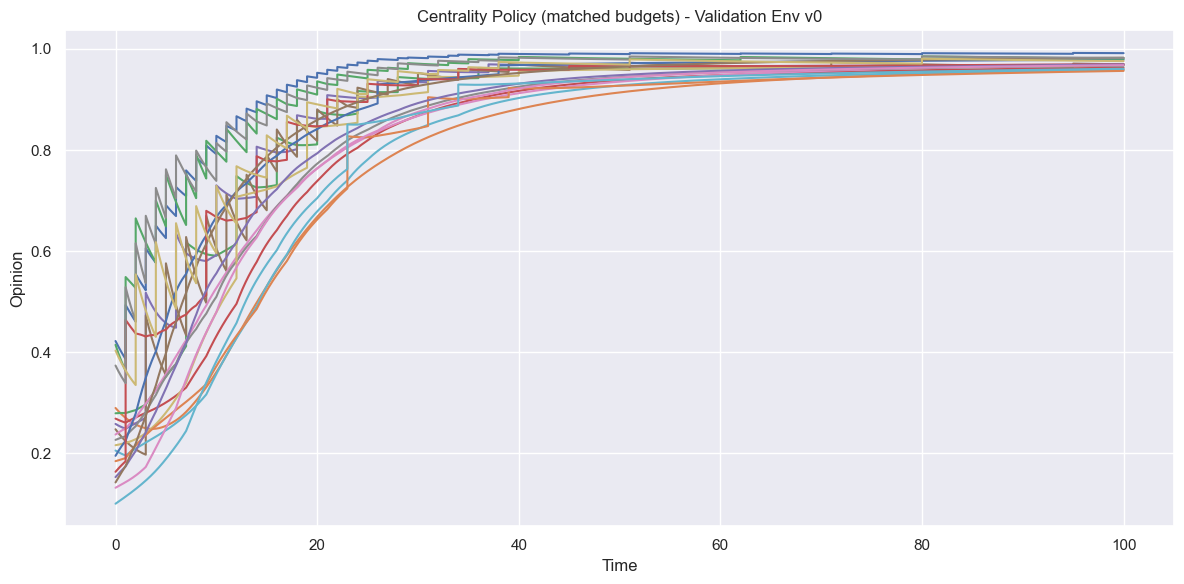

Total discounted reward: -13.2397

--- Running centrality policy for validation environment version 1 ---


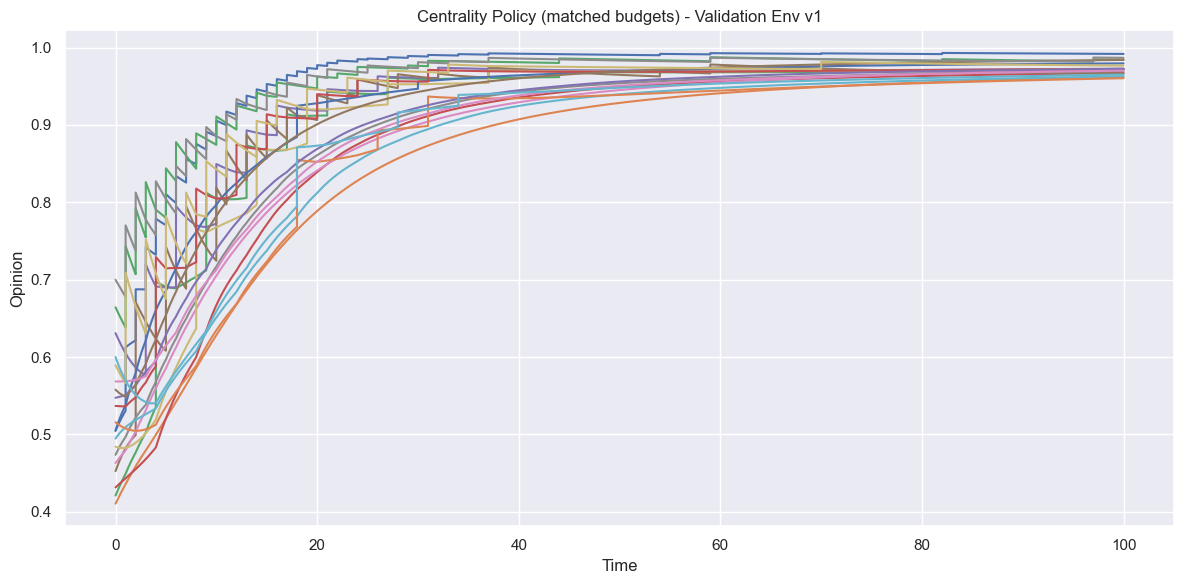

Total discounted reward: -8.7076

--- Running centrality policy for validation environment version 2 ---


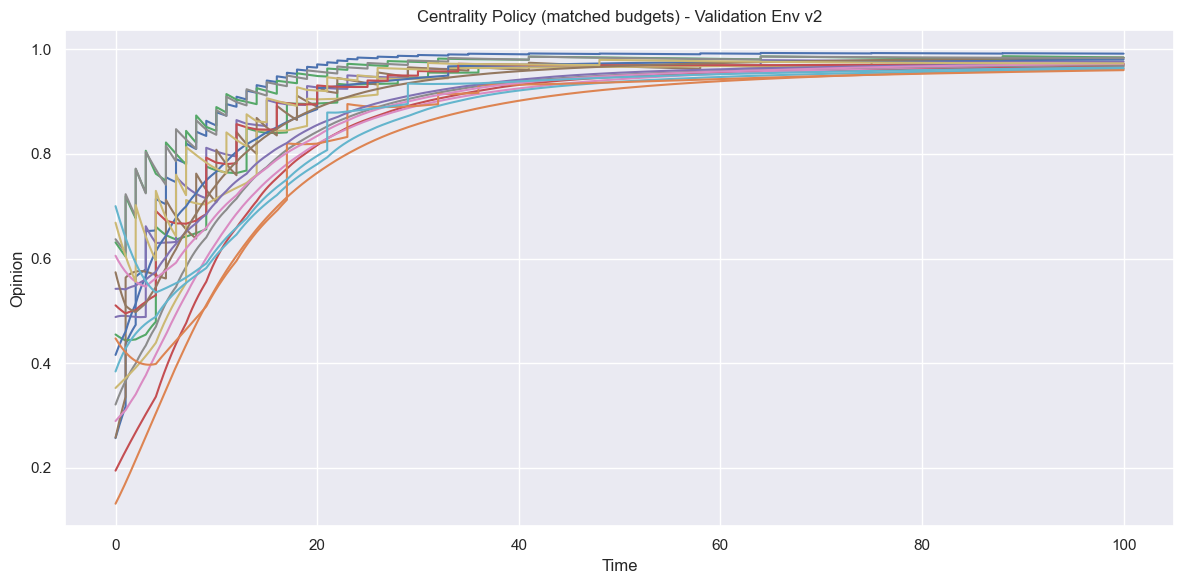

Total discounted reward: -9.8314
   version  discounted_reward
0        0         -13.239676
1        1          -8.707588
2        2          -9.831372


In [50]:
# --- Parameters ---
gamma = agent.gamma
nx = 2

factory = agent.env_factory
results = []

env_versions = factory.validation_versions
# env_versions = [0]

# Ensure df_actions exists (from your agent run):
df_actions = pd.concat(df_actions_list, ignore_index=True)

for version in range(len(env_versions)):
    print(f"\n--- Running centrality policy for validation environment version {version} ---")
    env = factory.get_validation_env(version=version)

    # NEW: build per-step budget schedule from the agent’s actions
    budget_schedule = build_budget_schedule_from_df(df_actions, version=version, num_steps=num_steps, fill=0.0)

    # If your agent actions were normalized (e.g., sum equals β in [0,1]),
    # and centrality expects the same units, keep scale=1.0.
    # Otherwise you can rescale: budget_schedule = available_budget * budget_schedule
    # budget_schedule = available_budget * budget_schedule

    # NEW: run centrality with the schedule
    opinions_over_time, time_points, rewards, actions, intermediary_states = run_centrality_policy_with_schedule(
        env, budget_schedule=budget_schedule, max_steps=num_steps
    )

    flat_states, flat_times = flatten_intermediate_states_np(intermediary_states, env.t_campaign, env.t_s)
    plot_opinions_over_time(flat_states, flat_times, title=f"Centrality Policy (matched budgets) - Validation Env v{version}")

    total_value = sum((gamma ** i) * r for i, r in enumerate(rewards))
    print(f"Total discounted reward: {total_value:.4f}")
    results.append({"version": version, "discounted_reward": total_value})

df_results_centrality = pd.DataFrame(results)
print(df_results_centrality)


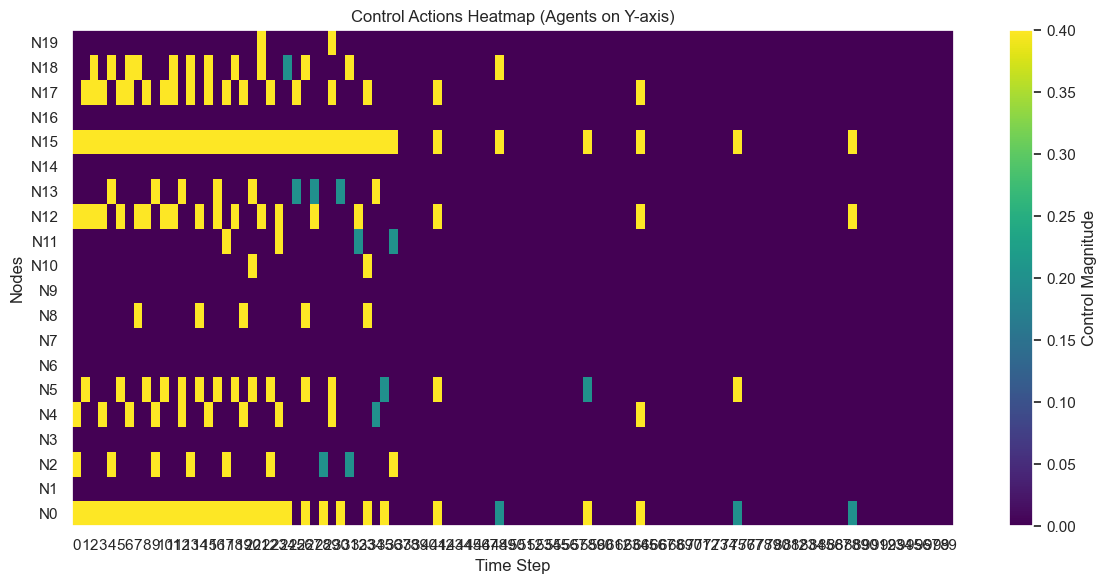

In [51]:
plot_action_heatmap(actions)

In [52]:
for df in (df_results_agent, df_results_centrality, df_results_uniform):
    df["version"] = df["version"].astype(int)

df_compare = (
    df_results_agent.rename(columns={"discounted_reward": "agent"})
    .merge(df_results_centrality.rename(columns={"discounted_reward": "centrality"}), on="version", how="outer")
    .merge(df_results_uniform.rename(columns={"discounted_reward": "uniform"}), on="version", how="outer")
    .sort_values("version")
    .reset_index(drop=True)
)

print(df_compare)

   version      agent  centrality    uniform
0        0 -10.362483  -13.239676 -50.975115
1        1  -7.016441   -8.707588 -31.987665
2        2  -8.039370   -9.831372 -10.712384
